In [1]:
import os
import numpy as np
import re
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import glob
import seaborn as sns

In [2]:
EXPPATH = r'F:\Storage\Dropbox\Datawork\NetworkDataset\BA\exp_20190803'

In [26]:
def read_to_labels(filename):
    """
    Reading setting file
    """
    filepath = os.path.join(EXPPATH, filename)
    results = []
    with open(filepath, 'r') as rf:
        lines = rf.readlines()
        for line in lines:
            lb = -1
            if 'original' in line:
                lb = 1
            elif 'dk2.5' in line:
                lb = 2
            elif 'dk2.1' in line:
                lb = 3
            elif 'dk2.0' in line:
                lb = 4
            elif 'dk1.0' in line:
                lb = 5
            if lb > 0:
                results.append(lb)
        rf.close()
    print('Number of files = {}'.format(len(results)))
    return np.array(results)

In [27]:
def get_kpca_gen_file(folder, exp_path, setting_file, T1, T2, tmax, interval, thres=0.0, infval=0.0):
    kername = setting_file.replace('barlist_', '')
    kername = kername.replace('.txt', '_method_0_T1_{}_T2_{}_tmax_{}_interval_{}_thres_{}_inf_{}.txt'.format(T1, T2, tmax, interval, thres, infval))
    kerpath = os.path.join(exp_path, folder)
    kerpath = os.path.join(kerpath, kername)
    return kerpath

In [28]:
def normalize_kernel(kermat):
    sm = np.sum(kermat.diagonal() <= 0)
    if sm > 0:
        print('Invalid kernel')
    else:
        D = np.diag(1.0/np.sqrt(np.diag(kermat)))
        kermat = np.dot(np.dot(D, kermat), D)
        print('Normalized matrix')
    return kermat

In [29]:
def kernel_PCA(kerfile, params, num_components, norm=False):
    cmp = cm.get_cmap('RdYlBu')
    if os.path.isfile(kerfile) == False:
        return
    kermat = np.loadtxt(kerfile)
    if norm:
        kermat = normalize_kernel(kermat)
    print('Kermat shape', kermat.shape)
    kpca = KernelPCA(kernel="precomputed")
    nums = kermat.shape[0]
    X = np.ones((nums, nums))
    X_kpca = kpca.fit_transform(kermat, X)
    transform_file = kerfile.replace('kernel', 'transform')
    if norm:
        transform_file = transform_file.replace('.txt', '_norm.txt')
    np.savetxt(transform_file, X_kpca, delimiter=',') 

In [52]:
def make_heatmap(setting_file, T1=0.0, T2=1.0, tmax=100.0, interval=1, thres=0.0, infval=0.0, norm=True, plot=False):
    params = read_to_labels(setting_file)
    nclass = len(np.unique(params))
    #N = len(params)
    #n = int(N / nclass)
    #spr = list(range(n))
    #for i in range(1, nclass):
    #    j = nclass - i
    #    spr = spr + list(range(j*n, (j+1)*n))
    #spr = np.argsort(params)
    kerfile = get_kpca_gen_file('kernel', EXPPATH, setting_file, T1, T2, tmax, interval, thres, infval)
    if os.path.isfile(kerfile):
        kermat = np.loadtxt(kerfile)
        if norm:
            kermat = normalize_kernel(kermat)
        #kermat = kermat[np.ix_(spr, spr)]
        #y = []
        #for i in range(kermat.shape[0]-1):
            #print(i, kermat[i, i+1])
            #y.append(kermat[i, i+1])
        fig = plt.figure(figsize=(7,5))
        #plt.plot(y)
        ax = sns.heatmap(kermat)
        if plot == True:
            plt.show()
        else:
            picfile = kerfile.replace('.txt', '.png')
            picfile = picfile.replace('kernel', 'plot')
            plt.savefig(picfile)
            print('Saved ', picfile)
    else:
        print("File not found: ", kerfile)

Number of files = 1000
Normalized matrix


<IPython.core.display.Javascript object>


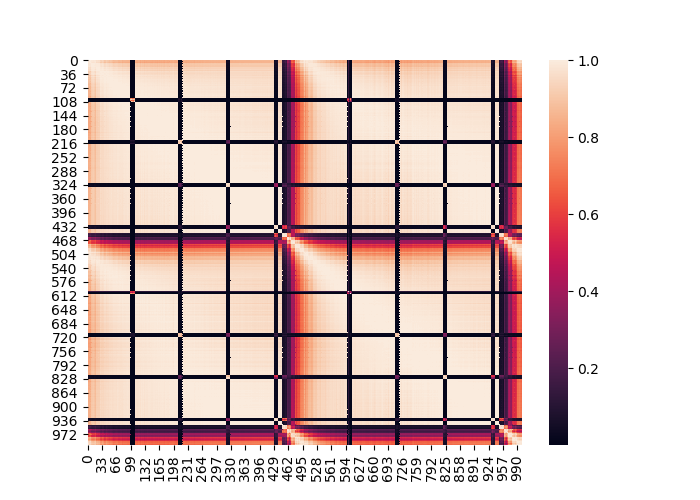

In [53]:
settingfile = 'barlist_config_join_10_d_1.txt'
make_heatmap(settingfile, tmax=100.0, plot=True)

In [31]:
def make_kPCA_transform(setting_file, T1=0.0, T2=1.0, tmax=100.0, interval=1, thres=0.0, infval=0.0, norm=False):
    """
    Save to transform file
    """
    params = read_to_labels(setting_file)
    kerfile = get_kpca_gen_file('kernel', EXPPATH, setting_file, T1, T2, tmax, interval, thres, infval)
    print(kerfile)
    kernel_PCA(kerfile, params, 3, norm)        

In [54]:
make_kPCA_transform(settingfile, tmax=100.0, norm=True)

Number of files = 1000
F:\Storage\Dropbox\Datawork\NetworkDataset\BA\exp_20190803\kernel\config_join_10_d_1_method_0_T1_0.0_T2_1.0_tmax_100.0_interval_1_thres_0.0_inf_0.0.txt
Normalized matrix
Kermat shape (1000, 1000)


In [35]:
def plot_kPCA(setting_file, n_components, T1=0.0, T2=1.0, tmax=100.0, interval=1, thres=0.0, infval=0.0, lbs=None, norm=False):
    params = read_to_labels(setting_file)
    n = len(params)
    params = params.reshape(n,1)
    transfile = get_kpca_gen_file('transform', EXPPATH, setting_file, T1, T2, tmax, interval, thres, infval)
    if norm:
        transfile = transfile.replace('.txt', '_norm.txt')
    X_kpca = np.loadtxt(transfile, delimiter=',')
    print('X_kpca shape', X_kpca.shape)
    
    if lbs is not None:
        selected_ids = []
        for i in range(n):
            if params[i] in lbs:
                selected_ids.append(i)
    else:
        selected_ids = range(n)
    selected_ids = np.ix_(selected_ids)
    
    %matplotlib notebook
    cmp = cm.get_cmap('RdYlBu')
    alpha = 0.5
    if n_components==3:
        fig = plt.figure(figsize=(7,5))
        ax = Axes3D(fig)
        sc=ax.scatter3D(X_kpca[selected_ids, 0], X_kpca[selected_ids, 1], X_kpca[selected_ids, 2], 'ro', c=params[selected_ids].ravel(), cmap=cmp, s=40)
        ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False) 
        ax.set_facecolor('k')
        sc.set_alpha(alpha)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        sc = ax.scatter(X_kpca[selected_ids, 0], X_kpca[selected_ids, 1], s=40, c=params[selected_ids,0], cmap=cmp)
        ax.set_facecolor('gray')
        ax.set_alpha(0.3)
    cbar = plt.colorbar(sc)
    cbar.set_alpha(alpha)
    cbar.draw_all()
    plt.show()

Number of files = 1000
X_kpca shape (1000, 595)


<IPython.core.display.Javascript object>


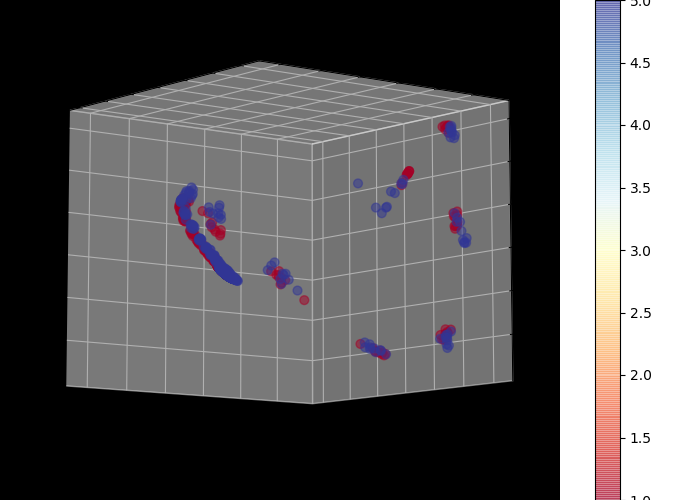

In [57]:
plot_kPCA(settingfile, n_components=3, tmax=100.0, lbs=None, norm=True)

Number of files = 2500
X_kpca shape (2500, 1486)


<IPython.core.display.Javascript object>


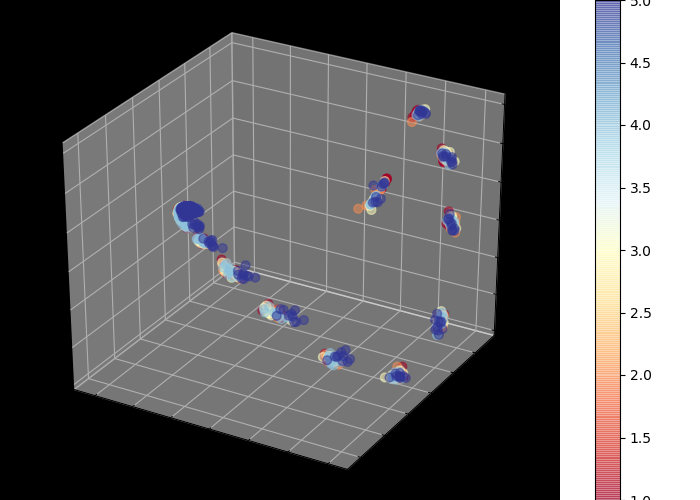

In [43]:
plot_kPCA(settingfile, n_components=3, tmax=100.0, lbs=None, norm=True)

Number of files = 2500
X_kpca shape (2500, 1487)


<IPython.core.display.Javascript object>


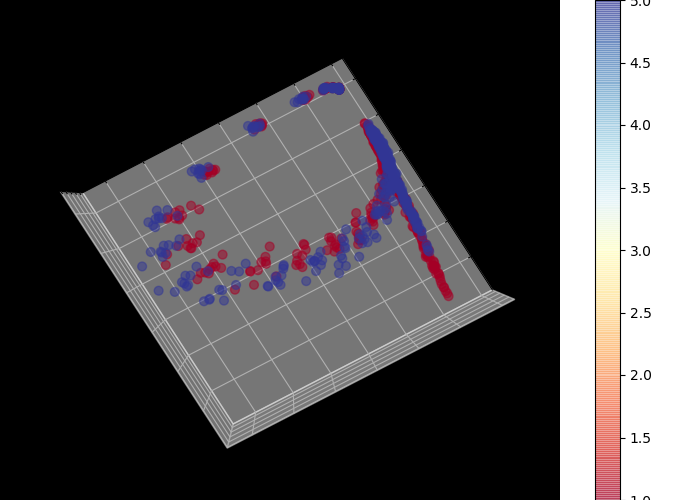

In [48]:
plot_kPCA(settingfile, n_components=3, tmax=100.0, lbs=[1, 5], norm=False)